In [79]:
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [80]:
def load_data(dataset_name='Cora'):
    # 下载数据集
    dataset = Planetoid(root=f'data', name=dataset_name, transform=NormalizeFeatures())
    # 只有一张图，所以直接返回第一个
    return dataset[0], dataset

In [81]:
# 加载数据集
data, dataset = load_data()
print(data)
print(dataset)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Cora()


In [82]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        # 定义两个GCN层
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        # 使用log_softmax作为输出层
        return F.log_softmax(x, dim=1)

In [83]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GAT, self).__init__()
        # 定义两个GAT层
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [95]:
class MyGCNLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyGCNLayer, self).__init__()
        # 定义一个线性层，输入是in_channels维，输出是out_channels维
        self.linear = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, adj):
        # 邻接矩阵和节点特征的传播：H = A'XW
        x = torch.mm(adj, x)
        x = self.linear(x)  # W * x
        return F.relu(x)  # ReLU激活

class MyGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MyGCN, self).__init__()
        # 手动实现GCN层，不使用GCNConv
        self.conv1 = MyGCNLayer(in_channels, hidden_channels)
        self.conv2 = MyGCNLayer(hidden_channels, out_channels)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        adj = torch.zeros((x.size(0), x.size(0)))
        rows, cols = edge_index
        # 设置邻接矩阵中的相应位置为1，表示有边相连
        adj[rows, cols] = 1
        # 加上自连接
        adj = adj + torch.eye(x.size(0))
        adj = adj.to(self.device)

        x = self.conv1(x, adj)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, adj)
        return F.log_softmax(x, dim=1)

In [96]:
def train(model, data, optimizer, criterion):
    model.train()
    # 梯度清零
    optimizer.zero_grad()
    # 前向传播
    out = model(data)
    # 计算损失，只计算训练集的损失
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    # 反向传播，计算梯度
    loss.backward()
    optimizer.step()
    return loss.item()

In [97]:
def test(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    # 计算验证集和测试集的准确率
    val_correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    val_acc = int(val_correct) / int(data.val_mask.sum())
    test_correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    test_acc = int(test_correct) / int(data.test_mask.sum())

    return val_acc, test_acc

In [98]:
# 设置超参数
hidden_channels = 128
learning_rate = 0.001
num_epochs = 200
# 结果汇总
results = {}

# 创建模型（选择GCN或GAT模型）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ", device)
data, dataset = load_data()
data = data.to(device)
model = GCN(in_channels=data.num_node_features, hidden_channels=hidden_channels, out_channels=dataset.num_classes).to(device)

# 使用Adam优化器和负对数似然损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.NLLLoss()

# 存储训练过程中的损失、验证集和测试集的准确率
losses = []
val_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    loss = train(model, data, optimizer, criterion)
    val_acc, test_acc = test(model, data)

    # 记录每个epoch的损失和准确率
    losses.append(loss)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


Using:  cuda
Epoch 0, Loss: 1.9458, Val Acc: 0.2000, Test Acc: 0.2420
Epoch 10, Loss: 1.9129, Val Acc: 0.6840, Test Acc: 0.7140
Epoch 20, Loss: 1.8691, Val Acc: 0.7040, Test Acc: 0.7090
Epoch 30, Loss: 1.8116, Val Acc: 0.7340, Test Acc: 0.7380
Epoch 40, Loss: 1.7478, Val Acc: 0.7480, Test Acc: 0.7500
Epoch 50, Loss: 1.6724, Val Acc: 0.7460, Test Acc: 0.7520
Epoch 60, Loss: 1.5842, Val Acc: 0.7480, Test Acc: 0.7580
Epoch 70, Loss: 1.4907, Val Acc: 0.7560, Test Acc: 0.7670
Epoch 80, Loss: 1.3987, Val Acc: 0.7660, Test Acc: 0.7710
Epoch 90, Loss: 1.2903, Val Acc: 0.7720, Test Acc: 0.7810
Epoch 100, Loss: 1.1760, Val Acc: 0.7740, Test Acc: 0.7850
Epoch 110, Loss: 1.0670, Val Acc: 0.7800, Test Acc: 0.7910
Epoch 120, Loss: 0.9705, Val Acc: 0.7800, Test Acc: 0.7940
Epoch 130, Loss: 0.8723, Val Acc: 0.7880, Test Acc: 0.7970
Epoch 140, Loss: 0.7891, Val Acc: 0.7880, Test Acc: 0.8000
Epoch 150, Loss: 0.6934, Val Acc: 0.7900, Test Acc: 0.8000
Epoch 160, Loss: 0.6228, Val Acc: 0.7920, Test Acc: 0.

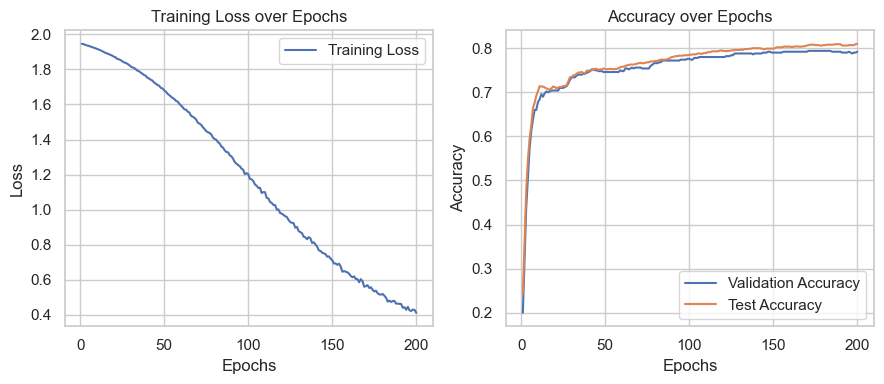

In [99]:
# 设置Seaborn的白色主题
sns.set_theme(style="whitegrid")

def plot_metrics_with_seaborn(losses, val_accuracies, test_accuracies):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(9, 4))
    # 绘制训练损失曲线
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    # 绘制验证集和测试集的准确率曲线
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=val_accuracies, label='Validation Accuracy')
    sns.lineplot(x=epochs, y=test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')

    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics_with_seaborn(losses, val_accuracies, test_accuracies)
results['GCN'] = (losses, val_accuracies, test_accuracies)

Epoch 0, Loss: 1.9452, Val Acc: 0.2860, Test Acc: 0.2850
Epoch 10, Loss: 1.8581, Val Acc: 0.7400, Test Acc: 0.7230
Epoch 20, Loss: 1.7477, Val Acc: 0.7800, Test Acc: 0.7890
Epoch 30, Loss: 1.5767, Val Acc: 0.7920, Test Acc: 0.7980
Epoch 40, Loss: 1.4642, Val Acc: 0.7980, Test Acc: 0.8100
Epoch 50, Loss: 1.2672, Val Acc: 0.7980, Test Acc: 0.8000
Epoch 60, Loss: 1.1546, Val Acc: 0.7860, Test Acc: 0.7930
Epoch 70, Loss: 0.9588, Val Acc: 0.7940, Test Acc: 0.7960
Epoch 80, Loss: 0.8442, Val Acc: 0.7920, Test Acc: 0.8030
Epoch 90, Loss: 0.7551, Val Acc: 0.7880, Test Acc: 0.8000
Epoch 100, Loss: 0.7600, Val Acc: 0.7940, Test Acc: 0.7890
Epoch 110, Loss: 0.7451, Val Acc: 0.7960, Test Acc: 0.8000
Epoch 120, Loss: 0.6833, Val Acc: 0.7940, Test Acc: 0.8000
Epoch 130, Loss: 0.6001, Val Acc: 0.7880, Test Acc: 0.7950
Epoch 140, Loss: 0.5055, Val Acc: 0.7920, Test Acc: 0.7920
Epoch 150, Loss: 0.7227, Val Acc: 0.7940, Test Acc: 0.7960
Epoch 160, Loss: 0.5212, Val Acc: 0.7920, Test Acc: 0.7890
Epoch 17

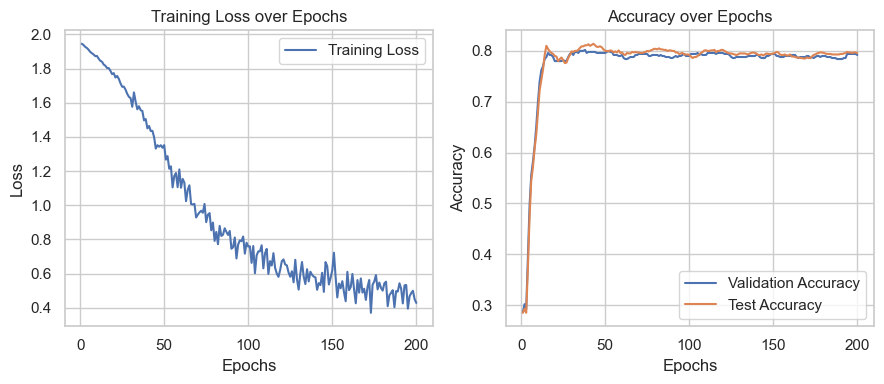

In [100]:
# 创建模型（选择GCN或GAT模型）
model = GAT(in_channels=data.num_node_features, hidden_channels=hidden_channels, out_channels=dataset.num_classes).to(device)

# 使用Adam优化器和负对数似然损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.NLLLoss()

# 存储训练过程中的损失、验证集和测试集的准确率
losses = []
val_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    loss = train(model, data, optimizer, criterion)
    val_acc, test_acc = test(model, data)

    # 记录每个epoch的损失和准确率
    losses.append(loss)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

plot_metrics_with_seaborn(losses, val_accuracies, test_accuracies)
results['GAT'] = (losses, val_accuracies, test_accuracies)

Epoch 0, Loss: 1.9473, Val Acc: 0.3780, Test Acc: 0.3540
Epoch 10, Loss: 1.5518, Val Acc: 0.7340, Test Acc: 0.7260
Epoch 20, Loss: 1.1964, Val Acc: 0.7680, Test Acc: 0.7720
Epoch 30, Loss: 0.9399, Val Acc: 0.7660, Test Acc: 0.7770
Epoch 40, Loss: 0.7036, Val Acc: 0.7660, Test Acc: 0.7630
Epoch 50, Loss: 0.5477, Val Acc: 0.7660, Test Acc: 0.7660
Epoch 60, Loss: 0.4145, Val Acc: 0.7840, Test Acc: 0.7750
Epoch 70, Loss: 0.3325, Val Acc: 0.7680, Test Acc: 0.7700
Epoch 80, Loss: 0.2704, Val Acc: 0.7740, Test Acc: 0.7700
Epoch 90, Loss: 0.2243, Val Acc: 0.7660, Test Acc: 0.7670
Epoch 100, Loss: 0.1819, Val Acc: 0.7680, Test Acc: 0.7670
Epoch 110, Loss: 0.1555, Val Acc: 0.7700, Test Acc: 0.7610
Epoch 120, Loss: 0.1279, Val Acc: 0.7640, Test Acc: 0.7640
Epoch 130, Loss: 0.1091, Val Acc: 0.7700, Test Acc: 0.7630
Epoch 140, Loss: 0.0933, Val Acc: 0.7740, Test Acc: 0.7570
Epoch 150, Loss: 0.0762, Val Acc: 0.7660, Test Acc: 0.7550
Epoch 160, Loss: 0.0643, Val Acc: 0.7660, Test Acc: 0.7570
Epoch 17

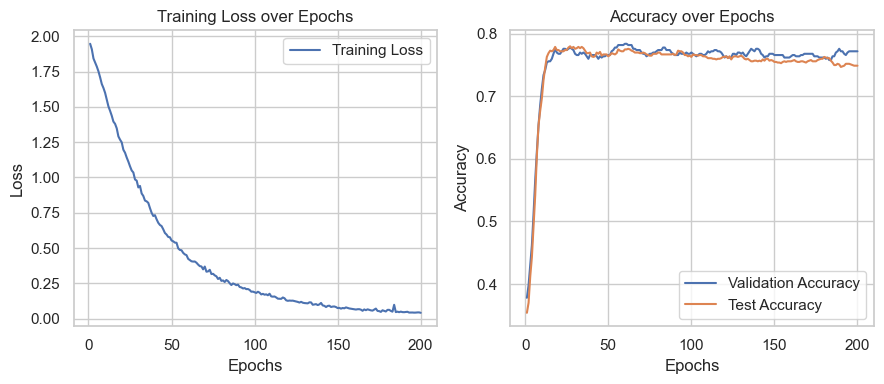

In [101]:
# 创建模型（使用自定义的GCN模型）
model = MyGCN(in_channels=data.num_node_features, hidden_channels=hidden_channels, out_channels=dataset.num_classes).to(device)

# 使用Adam优化器和负对数似然损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.NLLLoss()

# 存储训练过程中的损失、验证集和测试集的准确率
losses = []
val_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    loss = train(model, data, optimizer, criterion)
    val_acc, test_acc = test(model, data)

    # 记录每个epoch的损失和准确率
    losses.append(loss)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

plot_metrics_with_seaborn(losses, val_accuracies, test_accuracies)
results['MyGCN'] = (losses, val_accuracies, test_accuracies)

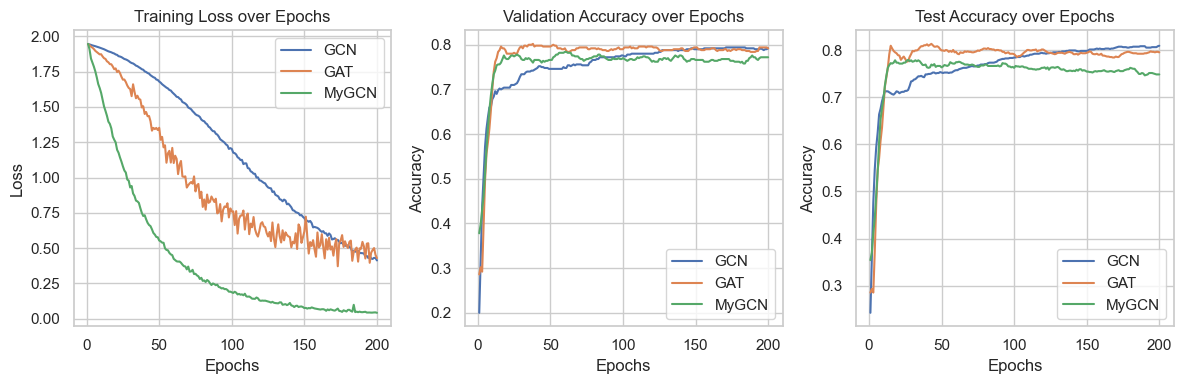

In [102]:
# 绘制三种模型的训练损失和验证集、测试集准确率曲线
plt.figure(figsize=(12, 4))

# 绘制训练损失曲线
plt.subplot(1, 3, 1)
for model_name, (losses, _, _) in results.items():
    sns.lineplot(x=range(1, len(losses) + 1), y=losses, label=model_name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')

# 绘制验证集准确率曲线
plt.subplot(1, 3, 2)
for model_name, (_, val_accuracies, _) in results.items():
    sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label=model_name)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')

# 绘制测试集准确率曲线
plt.subplot(1, 3, 3)
for model_name, (_, _, test_accuracies) in results.items():
    sns.lineplot(x=range(1, len(test_accuracies) + 1), y=test_accuracies, label=model_name)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')

plt.legend()
plt.tight_layout()
plt.show()